## 1. preliminary work, load in data and model

In [1]:
model_names = ["Original_Pretrained_R2plus1DMotionSegNet.pth"]

import os
os.chdir("/home/wang/workspace/JupyterNoteBooksAll/fully-automated-multi-heartbeat-echocardiography-video-segmentation-and-motion-tracking")
print(os.getcwd())

%config Completer.use_jedi = False

import SimpleITK as itk
from LabelFusion.wrapper import fuse_images

import echonet
from echonet.datasets import Echo

import torch.nn.functional as F
from torchvision.models.video import r2plus1d_18
from torch.utils.data import Dataset, DataLoader, Subset
from multiprocessing import cpu_count

from src.utils.torch_utils import TransformDataset, torch_collate
from src.utils.echo_utils import get2dPucks
from src.utils.camus_validate import cleanupSegmentation
from src.transform_utils import generate_2dmotion_field
from src.visualization_utils import categorical_dice
from src.loss_functions import huber_loss, convert_to_1hot, convert_to_1hot_tensor
from src.echonet_dataset import EDESpairs, EchoNetDynamicDataset

from src.model.R2plus1D_18_MotionNet import R2plus1D_18_MotionNet

# v1 dropout, not in place dropout
from src.model.dropout_0_10_R2plus1D_18_MotionNet import dropout_0_10_R2plus1D_18_MotionNet
from src.model.dropout_0_25_R2plus1D_18_MotionNet import dropout_0_25_R2plus1D_18_MotionNet
from src.model.dropout_0_50_R2plus1D_18_MotionNet import dropout_0_50_R2plus1D_18_MotionNet
from src.model.dropout_0_75_R2plus1D_18_MotionNet import dropout_0_75_R2plus1D_18_MotionNet

# v2 dropout (in place before motion heads)
from src.model.dropout_v2_0_00_R2plus1D_18_MotionNet import dropout_v2_0_00_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_10_R2plus1D_18_MotionNet import dropout_v2_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_25_R2plus1D_18_MotionNet import dropout_v2_0_25_R2plus1D_18_MotionNet



# from src.visualization_utils import categorical_dice

import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random
import pickle
import time

tic, toc = (time.time, time.time)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


batch_size = 4
num_workers = max(4, cpu_count()//2)


def worker_init_fn_valid(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def worker_init_fn(worker_id):
    # See here: https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    # and the original post of the problem: https://github.com/pytorch/pytorch/issues/5059#issuecomment-817373837
    worker_seed = torch.initial_seed() % 2 ** 32
    print(f'worker_seed: {worker_seed}')
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    

def permuter(list1, list2):
    for i1 in list1:
        for i2 in list2:
            yield (i1, i2)
            

param_trainLoader = {'collate_fn': torch_collate,
                     'batch_size': batch_size,
                     'num_workers': max(4, cpu_count()//2),
                     'worker_init_fn': worker_init_fn}

param_testLoader = {'collate_fn': torch_collate,
                    'batch_size': batch_size,
                    'shuffle': False,
                    'num_workers': max(4, cpu_count()//2),
                    'worker_init_fn': worker_init_fn}

paramLoader = {'train': param_trainLoader,
               'valid': param_testLoader,
               'test':  param_testLoader}


with open("fold_indexes/stanford_valid_sampled_indices", "rb") as infile:
    valid_mask = pickle.load(infile)
infile.close()

full_dataset = EchoNetDynamicDataset(split='val', clip_length="full", subset_indices=valid_mask, period=1)
test_dataset = EchoNetDynamicDataset(split='test', clip_length="full", raise_for_es_ed=False, period=1)
random_test_dataset = EchoNetDynamicDataset(split='test', clip_length=32, raise_for_es_ed=True, period=1)


loaded_in_models = []

for model_name in model_names:
    model_save_path = f"save_models/{model_name}"
     
    
    if model_name == 'Original_Pretrained_R2plus1DMotionSegNet.pth':
        model_template_obj = R2plus1D_18_MotionNet()
    elif model_name == 'dropout_v2_0_00_R2plus1DMotionSegNet.pth':
        model_template_obj = dropout_v2_0_00_R2plus1D_18_MotionNet()
        
    elif model_name == "dropout_v3_0_00_R2plus1D_18_MotionNet.pth":
        model_template_obj = dropout_v3_0_00_R2plus1D_18_MotionNet()
    elif model_name == "dropout_v3_0_10_R2plus1D_18_MotionNet.pth":
        model_template_obj = dropout_v3_0_10_R2plus1D_18_MotionNet()
    elif model_name == "dropout_v3_0_25_R2plus1D_18_MotionNet.pth":
        model_template_obj = dropout_v3_0_25_R2plus1D_18_MotionNet()
    elif model_name == "dropout_v4_0_00_R2plus1D_18_MotionNet.pth":
        model_template_obj = dropout_v4_0_00_R2plus1D_18_MotionNet()
    elif model_name == "dropout_v4_0_10_R2plus1D_18_MotionNet.pth":
        model_template_obj = dropout_v4_0_10_R2plus1D_18_MotionNet()
    elif model_name == "dropout_v4_0_25_R2plus1D_18_MotionNet.pth":
        model_template_obj = dropout_v4_0_25_R2plus1D_18_MotionNet()


    model = torch.nn.DataParallel(model_template_obj)


    
    model.to("cuda")
    torch.cuda.empty_cache()
    model.load_state_dict(torch.load(model_save_path)["model"])
    print(f'{model_name} has {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters.')
    model.eval();
    
    loaded_in_models.append((model_name, model))

print(len(loaded_in_models))



# test_pat_index = np.random.randint(len(test_dataset))
test_pat_index = 0 

video, (filename, EF, es_clip_index, ed_clip_index, es_index, ed_index, es_frame, ed_frame, es_label, ed_label) = test_dataset[test_pat_index]



def divide_to_consecutive_clips(video, clip_length=32, interpolate_last=False):
    source_video = video.copy()
    video_length = video.shape[1]
    left = video_length % clip_length
    if left != 0 and interpolate_last:
        source_video = torch.Tensor(source_video).unsqueeze(0)
        source_video = F.interpolate(source_video, size=(int(np.round(video_length / clip_length) * clip_length), 112, 112),
                                     mode="trilinear", align_corners=False)
        source_video = source_video.squeeze(0).squeeze(0)
        source_video = source_video.numpy()
    
    videos = np.empty(shape=(1, 3, clip_length, 112, 112))

    for start in range(0, int(clip_length * np.round(video_length / clip_length)), clip_length):
        one_clip = source_video[:, start: start + clip_length]
        one_clip = np.expand_dims(one_clip, 0)
        videos = np.concatenate([videos, one_clip])
    return videos[1:]


# goes thru a video and annotates where we can start clips given video length, clip length, etc.
def get_all_possible_start_points(ed_index, es_index, video_length, clip_length):
    assert es_index - ed_index > 0, "not a ED to ES clip pair"
    possible_shift = clip_length - (es_index - ed_index)
    allowed_right = video_length - es_index
    if allowed_right < possible_shift:
        return np.arange(ed_index - possible_shift + 1, video_length - clip_length + 1)
    if possible_shift < 0:
        return np.array([ed_index])
    elif ed_index < possible_shift:
        return np.arange(ed_index + 1)
    else:
        return np.arange(ed_index - possible_shift + 1, ed_index + 1)

    
    

    
    
possible_starts = get_all_possible_start_points(ed_index, es_index, video.shape[1], clip_length=32)
print(len(possible_starts))
print(possible_starts)


delta_ed_es = es_index - ed_index
print(f'delta_ed_es: {delta_ed_es}')



/home/wang/workspace/JupyterNoteBooksAll/fully-automated-multi-heartbeat-echocardiography-video-segmentation-and-motion-tracking


100%|██████████| 16/16 [00:01<00:00, 13.90it/s]


Original_Pretrained_R2plus1DMotionSegNet.pth has 31575731 parameters.
1
16
[117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132]
delta_ed_es: 16


In [2]:
video.shape, ed_index, es_index

((3, 248, 112, 112), 132, 148)

In [3]:
148+15

163

In [4]:
def generate_2dmotion_field_PLAY(x, offset):
    # Qin's code for joint_motion_seg learning works fine on our purpose too
    # Same idea https://discuss.pytorch.org/t/warp-video-frame-from-optical-flow/6013/5
    # print(x.shape)
    
    
    x_shape = x.shape
    # print(f'x_shape: {x_shape}')
    
    grid_w, grid_h = torch.meshgrid([torch.linspace(-1, 1, x_shape[2]), torch.linspace(-1, 1, x_shape[3])])  # (h, w)
    # print(f'grid_w.shape (meshgrid): {grid_w.shape}')
    # print(f'grid_h.shape (meshgrid): {grid_h.shape}')
    
    # this should just be moving the vars to gpu mem and doing some data type conversion to some
    # floating point precision
    grid_w = grid_w.cuda().float()
    grid_h = grid_h.cuda().float()
    
    # print(f'grid_w.shape .cuda().float(): {grid_w.shape}')
    # print(f'grid_h.shape .cuda().float(): {grid_h.shape}')

    grid_w = nn.Parameter(grid_w, requires_grad=False)
    grid_h = nn.Parameter(grid_h, requires_grad=False)
    # print(f'grid_w.shape (nn.Param): {grid_w.shape}')
    # print(f'grid_h.shape (nn.Param): {grid_h.shape}')


    # OLD 
    # offset_h, offset_w = torch.split(offset, 1, 1)
    # NEW , TESTING
    offset_h, offset_w = torch.split(offset, 1)
    
    # print(f'offset_h.shape (split): {offset_h.shape}')
    # print(f'offset_w.shape (split): {offset_w.shape}')
    
    offset_w = offset_w.contiguous().view(-1, int(x_shape[2]), int(x_shape[3]))  # (b*c, h, w)
    offset_h = offset_h.contiguous().view(-1, int(x_shape[2]), int(x_shape[3]))  # (b*c, h, w)
    
    # print(f'offset_h.shape (contiguous): {offset_h.shape}')
    # print(f'offset_w.shape (contiguous): {offset_w.shape}')
    
    offset_w = grid_w + offset_w
    offset_h = grid_h + offset_h
    
    # print(f'offset_w (grid_w + offset_w): {offset_w.shape}')
    # print(f'offset_h (grid_h + offset_h): {offset_h.shape}')
    
    offsets = torch.stack((offset_h, offset_w), 3)
    
    # print(f'offsets (stack): {offsets.shape}')

    # print('leaving generate_2dmotion_field')
    return offsets

def categorical_dice(prediction, truth, k, epsilon=1e-5):
    """
        Compute the dice overlap between the predicted labels and truth
        Not a loss
    """
    # Dice overlap metric for label value k
    A = (prediction == k)
    B = (truth == k)
    return 2 * np.sum(A * B) / (np.sum(A) + np.sum(B) + epsilon)

## 2. Pass first video's data thru the model

In [5]:
# segment using all models
all_segmentation_outputs = []
all_motion_outputs = []

# for each model, segment the clips
for name, model in loaded_in_models:
    
    segmentation_outputs = np.empty(shape=(1, 2, 32, 112, 112))
    motion_outputs = np.empty(shape=(1, 4, 32, 112, 112))
    for start in possible_starts:
        one_clip = np.expand_dims(video[:, start: start + 32], 0)
        segmentation_output, motion_output = model(torch.Tensor(one_clip))
        segmentation_outputs = np.concatenate([segmentation_outputs, segmentation_output.cpu().detach().numpy()])
        motion_outputs = np.concatenate([motion_outputs, motion_output.cpu().detach().numpy()])
    segmentation_outputs = segmentation_outputs[1:]
    motion_outputs = motion_outputs[1:]
    
    # save 
    all_segmentation_outputs.append(segmentation_outputs)
    all_motion_outputs.append(motion_outputs)


### 3. The fun part, we need to make sure our objects have the right shapes in order to pass them thru the motion manipulation functions that do the actual warping of the seg out images via the motion tracking information

In [6]:
motion_trackings = all_motion_outputs[0]
segmentations = all_segmentation_outputs[0]
segmentations.shape, motion_trackings.shape

((16, 2, 32, 112, 112), (16, 4, 32, 112, 112))

In [7]:
last_clip_segmentations = segmentations[-1]
last_clip_motions = motion_trackings[-1]
last_clip_segmentations.shape, last_clip_motions.shape

((2, 32, 112, 112), (4, 32, 112, 112))

In [8]:
# remember, we will want to continuously warp the previous frame that has been warped forward in time
# only the first frame that we start with will be the actual seg out frame

flow_source = None

# warping FORWARD from ED -> ES
for frame_index in range(delta_ed_es):
    # grab forward motion
    forward_motion = last_clip_motions[:2, frame_index,...]
    
    # grab the ED seg out frame to warp
    if frame_index == 0:
        flow_source = np.array([last_clip_segmentations[:, frame_index, ...]])
        flow_source = torch.from_numpy(flow_source).to(device).float()
    else:
        pass # use previous next_label as flow_source, should be redefined at end of previous loop iter
    
    # convert to tensors and move to gpu with float dtype
    forward_motion = torch.from_numpy(forward_motion).to(device).float()
    # generate motion field for forward motion
    motion_field = generate_2dmotion_field_PLAY(flow_source, forward_motion)
    # create frame i+1 relative to curr frame i 
    next_label = F.grid_sample(flow_source, motion_field, align_corners=False, mode="bilinear", padding_mode='border')
    # use i+1 frame as next loop iter's i frame
    flow_source = next_label
    
#     # looking at it
#     next_frame = next_label.cpu().detach().numpy()
    
#     next_frame = np.argmax(next_frame, 1)

#     plt.imshow(next_frame[0], cmap='gray')
#     plt.colorbar()

es_created_from_warping_ed = flow_source.cpu().detach().numpy()
es_created_from_warping_ed.shape

# warping BACKWARD from ED <- ES
for frame_index in range(delta_ed_es, -1, -1):
    # grab backward motion
    backward_motion = last_clip_motions[2:, frame_index,...]

    # grab the ES seg out frame to start
    if frame_index == delta_ed_es:
        flow_source = np.array([last_clip_segmentations[:, frame_index, ...]])
        flow_source = torch.from_numpy(flow_source).to(device).float()
    else:
        pass # use previous next_label as flow_source, should be redefined at end of previous loop iter
    
    # convert to tensors and move to gpu with float dtype
    backward_motion = torch.from_numpy(backward_motion).to(device).float()
    # generate motion field for backward motion
    motion_field = generate_2dmotion_field_PLAY(flow_source, backward_motion)
    # create frame i-1 relative to curr frame i 
    next_label = F.grid_sample(flow_source, motion_field, align_corners=False, mode="bilinear", padding_mode='border')
    # use i-1 frame as next loop iter's i frame
    flow_source = next_label

ed_created_from_warping_es = flow_source.cpu().detach().numpy()
ed_created_from_warping_es.shape

(1, 2, 112, 112)

In [9]:
ed_created_from_warping_es_display_version = np.argmax(ed_created_from_warping_es, 1)[0]

es_created_from_warping_ed_display_version = np.argmax(es_created_from_warping_ed, 1)[0]

# plt.imshow(es_created_from_ed_warping_display_version, cmap='gray')

### Compare the 3 ES that we now have. 
#### 1. ES Ground Truth <br> 2. ES Seg Out <br> 3. ES warped from ED Seg Out

#### Do the same for the different ED's

Dice (GT, Seg): 0.9272270958141337
Dice (GT, Warp): 0.9288860860359592
Dice (Seg, Warp): 0.9899467712007879


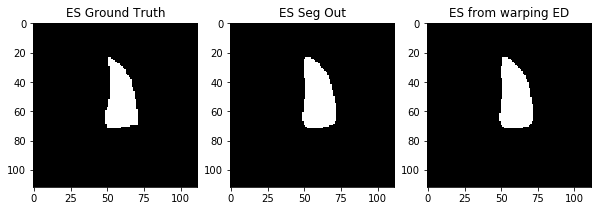

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

es_seg_out = np.argmax(last_clip_segmentations, 0)[delta_ed_es]

ax1.set_title('ES Ground Truth')
ax1.imshow(es_label, cmap='gray')

ax2.set_title('ES Seg Out')
ax2.imshow(es_seg_out, cmap='gray')

ax3.set_title('ES from warping ED')
ax3.imshow(es_created_from_warping_ed_display_version, cmap='gray')

print(f'Dice (GT, Seg): {categorical_dice(es_seg_out, es_label, k=1, epsilon=1e-5)}')
print(f'Dice (GT, Warp): {categorical_dice(es_created_from_warping_ed_display_version, es_label, k=1, epsilon=1e-5)}')
print(f'Dice (Seg, Warp): {categorical_dice(es_created_from_warping_ed_display_version, es_seg_out, k=1, epsilon=1e-5)}')

Dice (GT, Seg): 0.9661082938601157
Dice (GT, Warp): 0.9603998425205695
Dice (Seg, Warp): 0.9855732688474819


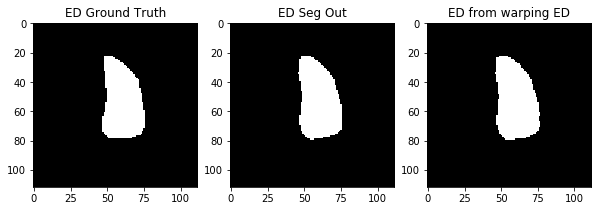

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ed_seg_out = np.argmax(last_clip_segmentations, 0)[0]

ax1.set_title('ED Ground Truth')
ax1.imshow(ed_label, cmap='gray')

ax2.set_title('ED Seg Out')
ax2.imshow(ed_seg_out, cmap='gray')

ax3.set_title('ED from warping ED')
ax3.imshow(ed_created_from_warping_es_display_version, cmap='gray')

print(f'Dice (GT, Seg): {categorical_dice(ed_seg_out, ed_label, k=1, epsilon=1e-5)}')
print(f'Dice (GT, Warp): {categorical_dice(ed_created_from_warping_es_display_version, ed_label, k=1, epsilon=1e-5)}')
print(f'Dice (Seg, Warp): {categorical_dice(ed_created_from_warping_es_display_version, ed_seg_out, k=1, epsilon=1e-5)}')